<a href="https://colab.research.google.com/github/HermanDp45/DLS_offline_2024/blob/main/Finding_a_girl_with_ginger_hair/Hair_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Parsing images from VK's groups

## Imports

In [45]:
import requests
import time

## Constants

In [ ]:
ACCESS_TOKEN = 'your_access_token_here'  # Replace with your VK access token
GROUP_ID = 'lovebmstu'  # Replace with your VK group ID
VERSION = '5.131'  # API version
COUNT = 200  # Number of users to fetch per request (maximum is 1000)

## Functions to get group mebers

In [51]:
def get_group_members(group_id, offset=0, count=1000):
    url = 'https://api.vk.com/method/groups.getMembers'
    params = {
        'group_id': group_id,
        'offset': offset,
        'count': count,
        'access_token': "",
        'fields': "sex,photo_max_orig",
        'v': "5.199"
    }

    response = requests.get(url, params=params)
    #print(response.status_code)
    return response.json()

# Fetch all user IDs
def fetch_all_members(group_id):
    all_members = []
    offset = 0
    count = 1000

    while True:
        response = get_group_members(group_id, offset, count)
        if 'response' not in response:
            break
        members = response['response'].get('items', [])
        all_members.extend(members)
        print(len(members), len(all_members))
        if len(members) < count:
            break

        offset += count
        time.sleep(0.3)  # To prevent hitting rate limits (3 requests per second)

    return all_members

## Getting

In [52]:
def save_members_to_file(members, file_path):
    with open(file_path, 'w', encoding='utf-8') as f:
        json.dump(members, f, ensure_ascii=False, indent=4)

GROUP_ID = 'lovebmstu'
user_ids = fetch_all_members(GROUP_ID)
print(f"Total members fetched: {len(user_ids)}")
save_members_to_file(user_ids, 'vk_group_members.json')

1000 1000
1000 2000
1000 3000
1000 4000
1000 5000
1000 6000
1000 7000
1000 8000
1000 9000
1000 10000
1000 11000
1000 12000
1000 13000
1000 14000
1000 15000
1000 16000
1000 17000
1000 18000
1000 19000
1000 20000
1000 21000
1000 22000
1000 23000
1000 24000
1000 25000
1000 26000
1000 27000
1000 28000
1000 29000
1000 30000
1000 31000
1000 32000
1000 33000
1000 34000
1000 35000
1000 36000
1000 37000
1000 38000
1000 39000
515 39515
Total members fetched: 39515


# AI For Detecting Hair Color

## Imports

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from google.colab import drive
from os.path import join

from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from keras.models import Model
from keras import optimizers
from tensorflow.keras.models import load_model
from scipy import stats
from random import seed
from random import randint

seed(23)
%matplotlib inline

## Extracting data

This code here extracts images, labels from .npy files and stores them in nupy arrays.

In [ ]:
import numpy as np
from os.path import join
from keras.utils import to_categorical
# Размер изображения и список цветов волос
image_size = 48
hair_colours = ['black', 'blond', 'brown', 'gray']

# Директория набора данных
dataset_directory = '/content/drive/MyDrive/HairDetecting/'

# Загрузка данных
images_train = np.load(join(dataset_directory, 'train_images.npy'))
labels_train = np.load(join(dataset_directory, 'train_labels.npy'))

images_val = np.load(join(dataset_directory, 'val_images.npy'))
labels_val = np.load(join(dataset_directory, 'val_labels.npy'))
# files_val = np.load(join(dataset_directory, 'val_files.npy'))

#images_test_public = np.load(join(dataset_directory, 'test_public_images.npy'))
#files_test_public = np.load(join(dataset_directory, 'test_public_files.npy'))

images_train = images_train.reshape([-1, image_size, image_size, 3]) / 255.0
images_val = images_val.reshape([-1, image_size, image_size, 3]) / 255.0
#images_test_public = images_test_public.reshape([-1, image_size, image_size, 3]) / 255.0

# Конвертация меток в one-hot encoding
train_labels = to_categorical(labels_train)
val_labels = to_categorical(labels_val)




## Data distribution graphics

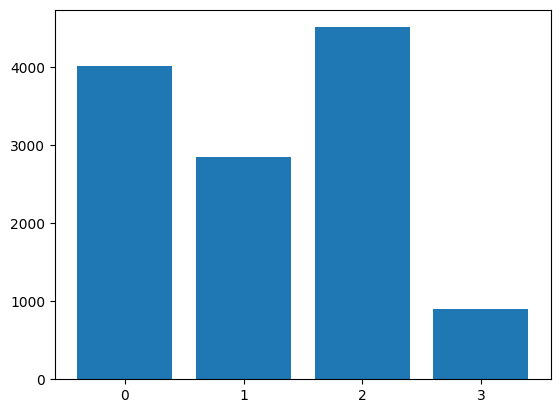

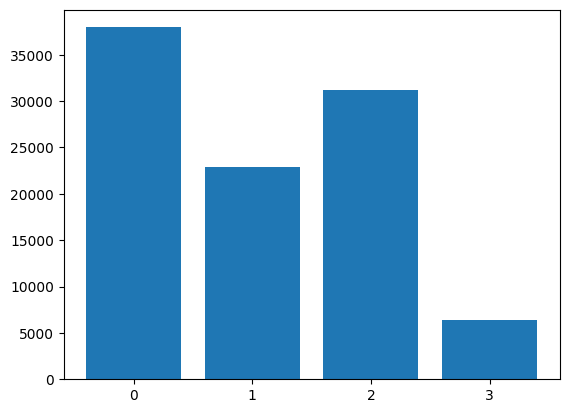

array([0., 1.], dtype=float32)

In [ ]:
import matplotlib.pyplot as plt
unique, counts = np.unique(labels_val, return_counts=True)
val = dict(zip(unique, counts))

unique, counts = np.unique(labels_train, return_counts=True)
train = dict(zip(unique, counts))

D = val
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

D = train
plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

np.unique(labels_train)
np.unique(train_labels)

## Function for normalized and balenced splitting (not used: the lack of RAM)

In [ ]:
def split_balanced(data, target, test_size=0.2):

    classes = np.unique(target)
    print(classes)
    # can give test_size as fraction of input data size of number of samples
    if test_size<1:
        n_test = np.round(len(target)*test_size)
    else:
        n_test = test_size
    n_train = max(0,len(target)-n_test)
    n_train_per_class = max(1,int(np.floor(n_train/len(classes))))
    n_test_per_class = max(1,int(np.floor(n_test/len(classes))))

    ixs = []
    for cl in classes:
        if (n_train_per_class+n_test_per_class) > np.sum(target==cl):
            # if data has too few samples for this class, do upsampling
            # split the data to training and testing before sampling so data points won't be
            #  shared among training and test data
            splitix = int(np.ceil(n_train_per_class/(n_train_per_class+n_test_per_class)*np.sum(target==cl)))
            ixs.append(np.r_[np.random.choice(np.nonzero(target==cl)[0][:splitix], n_train_per_class),
                np.random.choice(np.nonzero(target==cl)[0][splitix:], n_test_per_class)])
        else:
            ixs.append(np.random.choice(np.nonzero(target==cl)[0], n_train_per_class+n_test_per_class,
                replace=False))

    # take same num of samples from all classes
    ix_train = np.concatenate([x[:n_train_per_class] for x in ixs])
    ix_test = np.concatenate([x[n_train_per_class:(n_train_per_class+n_test_per_class)] for x in ixs])

    X_train = data[ix_train,:]
    X_test = data[ix_test,:]
    y_train = target[ix_train]
    y_test = target[ix_test]

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = split_balanced(images_train,
                                                    labels_train,
                                                    test_size=0.25)


[0 1 2 3]


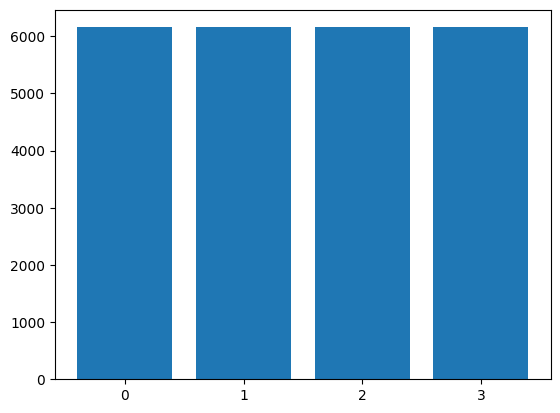

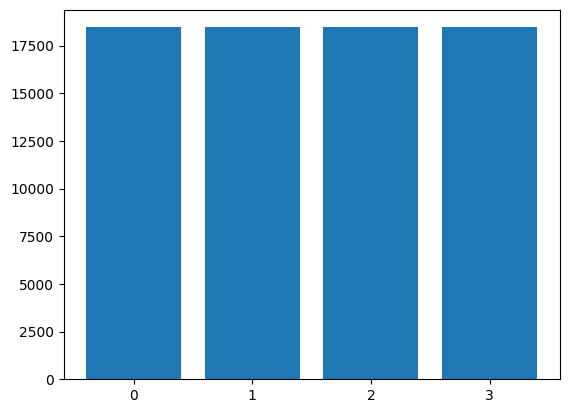

In [ ]:
import matplotlib.pyplot as plt
unique, counts = np.unique(y_test, return_counts=True)
val = dict(zip(unique, counts))

unique, counts = np.unique(y_train, return_counts=True)
train = dict(zip(unique, counts))
D = val

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()
D = train

plt.bar(range(len(D)), list(D.values()), align='center')
plt.xticks(range(len(D)), list(D.keys()))
plt.show()

## Examples from data

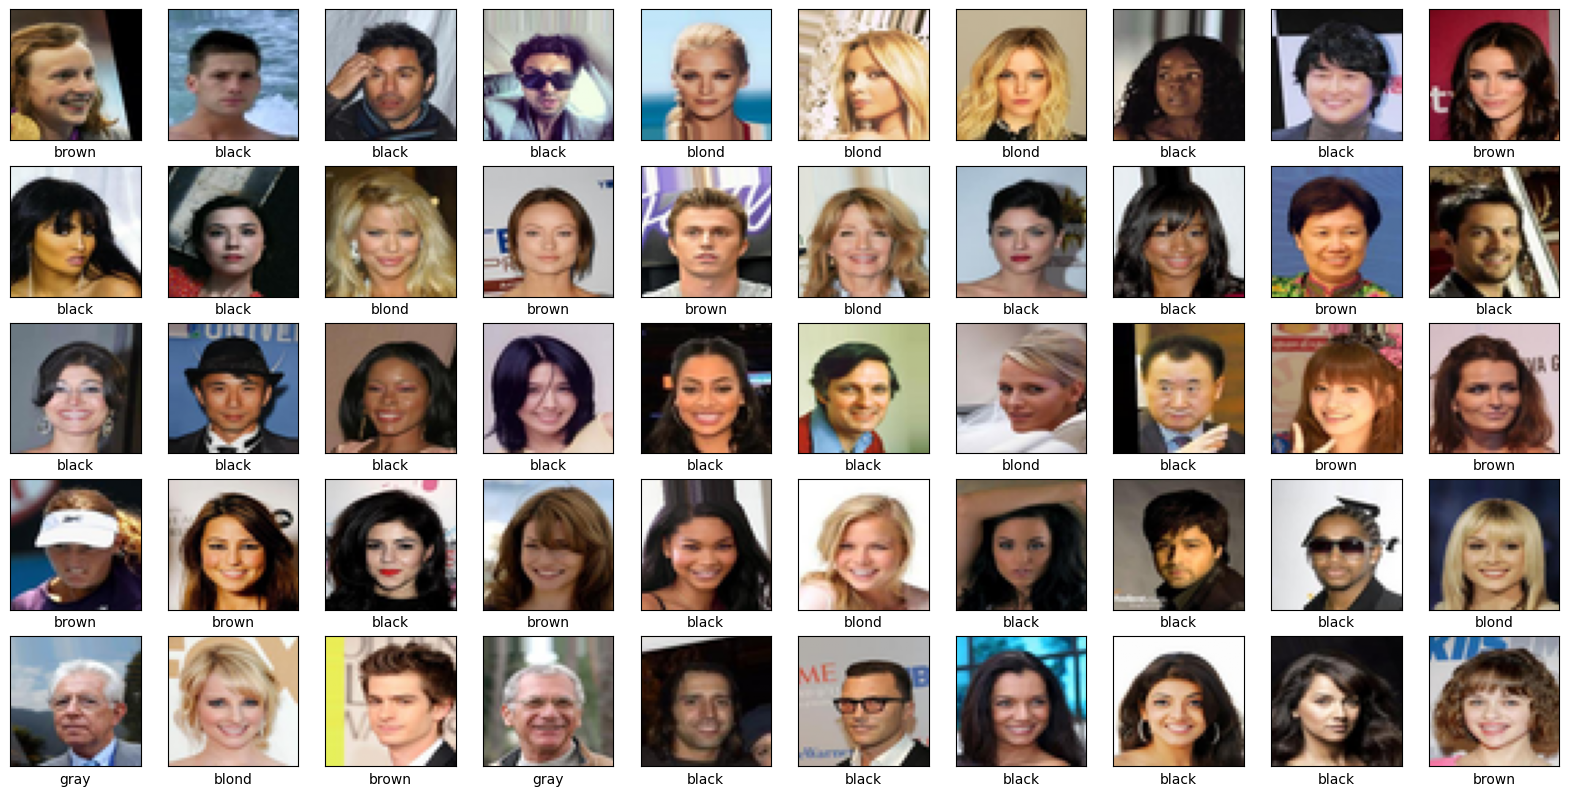

In [ ]:
from random import seed
from random import randint

seed(23)

plt.figure(figsize=(20,20))
for i in range(50):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    num = randint(0,len(images_train))
    plt.imshow(images_train[num], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays,
    # which is why you need the extra index
    plt.xlabel(hair_colours[labels_train[num]])
plt.show()

## Functions for displayning the history of tran & val losses

In [ ]:
def plot_history(model,epoch):
  history = model.history
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss=history.history['loss']
  val_loss=history.history['val_loss']

  epochs_range = range(epoch)

  plt.figure(figsize=(25, 10))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()


def download_results(model):
  pred_public = np.argmax(model.predict(images_test_public), axis=-1)
  df = pd.DataFrame(
    {'ID': files_test_public,
     'Prediction': pred_public
    })
  df[['Prediction']] = df[['Prediction']].astype(int)
  df.to_csv('RESULTS.csv', index=False)
  files.download("RESULTS.csv")

def val_accuracy(model,val_X,val_y):
  pred_val = np.argmax(model.predict(val_X), axis=-1)
  print('Validation Accuracy',accuracy_score(np.argmax(val_y, axis=1) , pred_val))


## Training model VGG16 with additions

In [ ]:
img_rows, img_cols, img_channel = 48, 48, 3

base_model = keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_rows, img_cols, img_channel))

add_model = Sequential()
add_model.add(Flatten(input_shape=base_model.output_shape[1:]))
add_model.add(Dense(4, activation='sigmoid'))
modelVGG_raw = Model(inputs=base_model.input, outputs=add_model(base_model.output))


modelVGG_raw.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

modelVGG_raw.summary()

batch_size = 128
epochs = 10 #50

train_datagen = ImageDataGenerator(
        rotation_range=30,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True)
train_datagen.fit(images_train)

def scheduler(epoch):
  if epoch < 10:
    return 0.001
  else:
    return 0.001 * tf.math.exp(0.1 * (10 - epoch))

callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = modelVGG_raw.fit_generator(
    train_datagen.flow(images_train, train_labels, batch_size=batch_size),
    steps_per_epoch=images_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(images_val, val_labels),
    callbacks=[callback]
)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

<ipython-input-4-44f3207e8304>:34: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = modelVGG_raw.fit_generator(


Epoch 1/10
769/769 [==============================] - 140s 168ms/step - loss: 0.2196 - accuracy: 0.8114 - val_loss: 0.1547 - val_accuracy: 0.8767 - lr: 0.0010
Epoch 2/10
769/769 [==============================] - 121s 158ms/step - loss: 0.1557 - accuracy: 0.8755 - val_loss: 0.1414 - val_accuracy: 0.8842 - lr: 0.0010
Epoch 3/10
769/769 [==============================] - 119s 155ms/step - loss: 0.1373 - accuracy: 0.8912 - val_loss: 0.1331 - val_accuracy: 0.8973 - lr: 0.0010
Epoch 4/10
769/769 [==============================] - 121s 158ms/step - loss: 0.1279 - accuracy: 0.8991 - val_loss: 0.1434 - val_accuracy: 0.8889 - lr: 0.0010
Epoch 5/10
769/769 [==============================] - 122s 159ms/step - loss: 0.1236 - accuracy: 0.9031 - val_loss: 0.1397 - val_accuracy: 0.8901 - lr: 0.0010
Epoch 6/10
769/769 [==============================] - 121s 157ms/step - loss: 0.1188 - accuracy: 0.9073 - val_loss: 0.1373 - val_accuracy: 0.8901 - lr: 0.0010
Epoch 7/10
769/769 [==========================

In [ ]:
modelVGG_raw.save('/content/drive/MyDrive/HairDetecting/vgg_raw')
# modelVGG_raw = load_model('/content/drive/MyDrive/HairDetecting/vgg_raw')

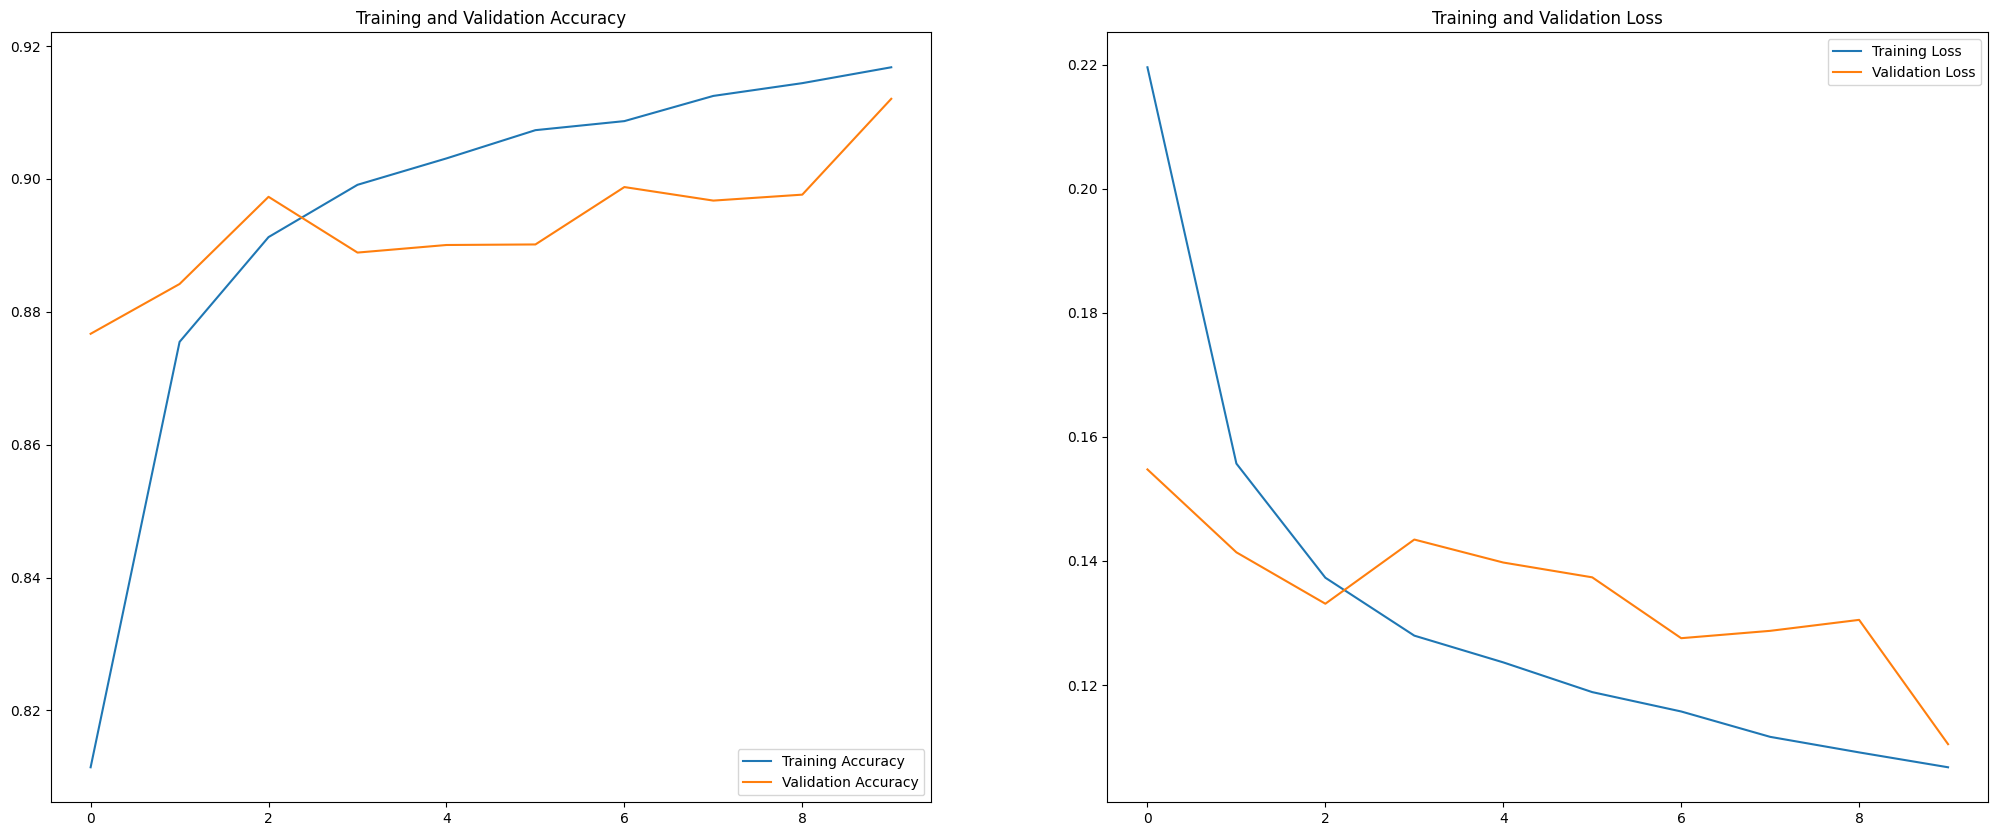

384/384 [==============================] - 5s 11ms/step
Validation Accuracy 0.9120619396903016


In [ ]:
plot_history(modelVGG_raw,epochs)
val_accuracy(modelVGG_raw,images_val, val_labels)

## Prediction Test

In [2]:
from keras.preprocessing.image import load_img, img_to_array
def preprocess_image(image_path, target_size=(48, 48)):
    # Загрузка изображения и его преобразование в массив numpy
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    # Нормализация изображения
    img_array = img_array / 255.0
    # Добавление размерности для батча
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [ ]:
image_path = '/content/RW.jpg'
processed_image = preprocess_image(image_path)

prediction = modelVGG_raw.predict(processed_image)

hair_colours = ['black', 'blond', 'brown', 'gray']
predicted_class = np.argmax(prediction)
predicted_hair_colour = hair_colours[predicted_class]

print("Predicted class probabilities:", prediction)
print("Predicted class:", predicted_class)
print("Predicted hair colour:", predicted_hair_colour)

1/1 [==============================] - 0s 18ms/step
Predicted class probabilities: [[0.00451342 0.33673462 0.65226054 0.00183331]]
Predicted class: 2
Predicted hair colour: brown


## Functions for predicting colors (Black, Brown, Blond, Gray, Ginger?)

In [14]:
from keras.preprocessing.image import img_to_array

def preprocess_image(image, target_size=(48, 48)):
    # Изменение размера изображения
    image = cv2.resize(image, target_size)
    img_array = img_to_array(image)
    # Нормализация изображения
    img_array = img_array / 255.0
    # Добавление размерности для батча
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [60]:
def VGG16_predict(modelVGG_raw, crop_img):
  processed_image = preprocess_image(crop_img)

  prediction = modelVGG_raw.predict(processed_image)
  #print(prediction)

  hair_colours = ['black', 'blond', 'brown', 'gray']

  if (1 - prediction[0][1] + prediction[0][2]) < 0.8 and prediction[0][1] > 0.15 and prediction[0][2] > 0.15:
    return 'ginger'
  else:
    predicted_class = np.argmax(prediction)
    return hair_colours[predicted_class]

# Getting Pictures of person's head

Необходимо получить фотографию лица из изначальной фотографии./

Для этого я воспользуюсь **Haar Cascade classifier from OpenCV**

## Imports

In [10]:
import cv2
import json
import os
import numpy as np
import requests

## Getting a list with women

In [55]:
w_members = []

with open('/content/vk_group_members.json', 'r', encoding='utf-8') as file:
  # Load the JSON data
  data = json.load(file)
  for user_data in data:
    # Access fields
    # user_id = user_data.get('id', None)
    # photo_url = user_data.get('photo_max_orig', None)
    #first_name = user_data.get('first_name', '')
    # last_name = user_data.get('last_name', '')
    sex = user_data.get('sex', None)
    deactivated = user_data.get('deactivated', None)
    # can_access_closed = user_data.get('can_access_closed', False)
    # is_closed = user_data.get('is_closed', False)

    # Process the data (example: print user info)
    if not deactivated and sex == 1:
        w_members.append(user_data)
        # print(f"ID: {user_id}, Name: {first_name} {last_name}, Photo URL: {photo_url}")
  # print(w_members, "O")


In [56]:
print(w_members[:10], "O")

[{'id': 29819, 'photo_max_orig': 'https://sun1-25.userapi.com/s/v1/if1/uUK4_Om0CRKA0W3HE0gB9wKKe4QPhrpOLXq1lZTx13SmyWVLrJozFwzmQetWwnJ95fUocOMK.jpg?size=400x400&quality=96&crop=0,0,563,563&ava=1', 'sex': 1, 'first_name': 'Наталья', 'last_name': 'Минеева', 'can_access_closed': True, 'is_closed': False}, {'id': 86367, 'photo_max_orig': 'https://sun1-21.userapi.com/s/v1/if1/Er7QgMIw-jhC_z8LmlIJ3XDFncHY35mJKxfut6fqjBUEsFPqOK_dqr17J7SPd8NqanhOwjJN.jpg?size=400x400&quality=96&crop=0,341,1365,1365&ava=1', 'sex': 1, 'first_name': 'Евгения', 'last_name': 'Золотова', 'can_access_closed': True, 'is_closed': False}, {'id': 92254, 'photo_max_orig': 'https://sun1-27.userapi.com/s/v1/ig2/p8jFcneL9Ovxu-D_55SGmo1moLxHghtIXpZ30L2AqtyjO2ETWk26gBOYf43yoQt6AcGaaM26DGODtCSe1Hgg9xes.jpg?size=400x536&quality=96&crop=25,0,688,922&ava=1', 'sex': 1, 'first_name': 'Yulia', 'last_name': 'Ark', 'can_access_closed': True, 'is_closed': False}, {'id': 95276, 'photo_max_orig': 'https://sun1-98.userapi.com/s/v1/if1/OmtQ

In [ ]:
len(w_members)

## Functions for downloading pictures of members (not used)

In [ ]:
# Function to download an image from a URL and save it to a directory
def download_image(url, save_path):
  response = requests.get(url)
  if response.status_code == 200:
    with open(save_path, 'wb') as file:
      file.write(response.content)
  else:
    print(f"Failed to download image from {url}")

# Function to process user data from the JSON file and download images
def process_user_data(file_path, download_dir, members):
  # Create the download directory if it doesn't exist
  if not os.path.exists(download_dir):
    os.makedirs(download_dir)

  for member in members:
    user_id = member['id']
    photo_url = member['photo_max_orig']

    image_filename = f"{user_id}.jpg"
    save_path = os.path.join(download_dir, image_filename)

    # Download and save the image
    download_image(photo_url, save_path)
    print(f"Downloaded image for ID: {user_id})")



In [ ]:
process_user_data('/content/vk_group_members.json', '/content/downloaded_images', w_members)

Downloaded image for ID: 29819)
Downloaded image for ID: 86367)
Downloaded image for ID: 92254)
Downloaded image for ID: 95276)
Downloaded image for ID: 107644)
Downloaded image for ID: 118740)
Downloaded image for ID: 130717)
Downloaded image for ID: 152704)
Downloaded image for ID: 160922)
Downloaded image for ID: 171038)
Downloaded image for ID: 223595)
Downloaded image for ID: 226460)
Downloaded image for ID: 239793)
Downloaded image for ID: 240923)
Downloaded image for ID: 254291)
Downloaded image for ID: 295418)
Downloaded image for ID: 313386)
Downloaded image for ID: 361298)
Downloaded image for ID: 369914)
Downloaded image for ID: 381597)
Downloaded image for ID: 396574)
Downloaded image for ID: 404636)
Downloaded image for ID: 449158)
Downloaded image for ID: 485971)
Downloaded image for ID: 539978)
Downloaded image for ID: 546480)
Downloaded image for ID: 631534)
Downloaded image for ID: 645547)
Downloaded image for ID: 663301)
Downloaded image for ID: 667804)
Downloaded ima

KeyboardInterrupt: 

### Detecting head from downloaded picture

In [ ]:
# Reading the image
img = cv2.imread('/content/downloaded_images/815785.jpg')

if img is None:
    print("Error: Could not read the image. Check the file path.")
else:
  # Converting image to grayscale
  gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  # Loading the required Haar-cascade XML classifier file
  haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

  # Applying the face detection method on the grayscale image
  faces_rect = haar_cascade.detectMultiScale(gray_img, 1.1, 9)

  # Margin to include hair
  margin = 50  # Adjust as necessary

  # Iterating through rectangles of detected faces
  for (x, y, w, h) in faces_rect:
      # Adjust the coordinates to include margin
      x_new = max(0, x - margin)
      y_new = max(0, y - margin)
      w_new = min(img.shape[1], x + w + 2 * margin) - x_new - margin
      h_new = min(img.shape[0], y + h + 2 * margin) - y_new - margin

      cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

      # Crop and save the detected head region
      crop_img = img[y_new:y_new + h_new, x_new:x_new + w_new]
      cv2.imwrite(f'head_{x}_{y}.jpg', crop_img)

  #cv2.imshow('Detected heads', img)

  cv2.waitKey(0)
  cv2.destroyAllWindows()

True

## Function for strimming analysing pictures of members

need to fix (For ) (and here need to use the ai model to predict color of hair)

In [17]:
modelVGG_raw = load_model('/content/drive/MyDrive/HairDetecting/vgg_raw')

In [62]:
# Загрузка требуемого файла каскада Хаара
haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
margin = 50
results = []
i = 0

for member in w_members:
    url = member['photo_max_orig']
    id = member['id']
    #print(url)
    resp = requests.get(url, stream=True).raw
    image = np.asarray(bytearray(resp.read()), dtype="uint8")
    image = cv2.imdecode(image, cv2.IMREAD_COLOR)

    # Преобразование изображения в градации серого, если требуется
    gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Применение метода обнаружения лиц к изображению
    faces_rect = haar_cascade.detectMultiScale(gray_img, 1.1, 9)
    i += 1
    if i % 50 == 0:
      print(i)

    # Пометка обнаруженных лиц на изображении
    for (x, y, w, h) in faces_rect:
        x_new = max(0, x - margin)
        y_new = max(0, y - margin)
        w_new = min(image.shape[1], x + w + 2 * margin) - x_new - margin
        h_new = min(image.shape[0], y + h + 2 * margin) - y_new - margin

        #cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

        # Crop and save the detected head region
        crop_img = image[y_new:y_new + h_new, x_new:x_new + w_new]
        # cv2.imwrite(f'head_{id}_{i}_with_rec.jpg', crop_img)


        prediction = VGG16_predict(modelVGG_raw, crop_img)
        if prediction == "blond" or "ginger":
          results.append({
            'Name': member['first_name'],
            'ID': member['id'],
            'Gender': member['sex'],
            'Profile URL': "https://vk.com/id" + str(member['id']),
            'Hair Colour': prediction,
        })

df = pd.DataFrame(results)
df.to_excel('members_hair_colours.xlsx', index=False)

    # Сохранение изображения с обозначенными лицами
    #cv2.imwrite('detected_faces.jpg', image)


1/1 [==============================] - 0s 170ms/step
50
1/1 [==============================] - 0s 49ms/step
100
1/1 [==============================] - 0s 49ms/step
150
1/1 [==============================] - 0s 48ms/step
200
1/1 [==============================] - 0s 48ms/step
250
1/1 [==============================] - 0s 94ms/step
300
1/1 [==============================] - 0s 48ms/step
350
1/1 [==============================] - 0s 52ms/step
400
1/1 [==============================] - 0s 50ms/step
450
1/1 [==============================] - 0s 49ms/step
500
1/1 [==============================] - 0s 49ms/step
550
1/1 [==============================] - 0s 48ms/step
600
1/1 [==============================] - 0s 49ms/step


KeyboardInterrupt: 

In [63]:
df = pd.DataFrame(results)
df.to_excel('members_hair_colours.xlsx', index=False)

In [64]:
print(results[:10])

[{'Name': 'Наталья', 'ID': 29819, 'Gender': 1, 'Profile URL': 'https://vk.com/id29819', 'Hair Colour': 'black'}, {'Name': 'Наталья', 'ID': 29819, 'Gender': 1, 'Profile URL': 'https://vk.com/id29819', 'Hair Colour': 'black'}, {'Name': 'Евгения', 'ID': 86367, 'Gender': 1, 'Profile URL': 'https://vk.com/id86367', 'Hair Colour': 'blond'}, {'Name': 'Евгения', 'ID': 86367, 'Gender': 1, 'Profile URL': 'https://vk.com/id86367', 'Hair Colour': 'gray'}, {'Name': 'Yulia', 'ID': 92254, 'Gender': 1, 'Profile URL': 'https://vk.com/id92254', 'Hair Colour': 'black'}, {'Name': 'Анастасия', 'ID': 130717, 'Gender': 1, 'Profile URL': 'https://vk.com/id130717', 'Hair Colour': 'gray'}, {'Name': 'Алина', 'ID': 171038, 'Gender': 1, 'Profile URL': 'https://vk.com/id171038', 'Hair Colour': 'black'}, {'Name': 'Евгения', 'ID': 223595, 'Gender': 1, 'Profile URL': 'https://vk.com/id223595', 'Hair Colour': 'black'}, {'Name': 'Наталья', 'ID': 240923, 'Gender': 1, 'Profile URL': 'https://vk.com/id240923', 'Hair Colour